In [ ]:
pip install pygad

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
pip install Keras-Applications

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
pip install torchvision 

# Importación de librerias

In [ ]:
import torch
#import torchga
import pygad

In [ ]:
#Librerias
import cv2
from google.colab.patches import cv2_imshow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

#Otras librerias necesarias de keras

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
#from tensorflow.python.keras.applications import ResNet50
#from tensorflow.python.keras.models import Sequential
#from tensorflow.python.keras.layers import Dense

# Librerias para algoritmos geneticos
import tensorflow.keras
import pygad.kerasga
import pygad
import tensorflow as tf

from keras.utils.vis_utils import plot_model

#Carga de los datos

**ACCESO A GOOGLE DRIVE para Cargar Data**

In [ ]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

% cd /content/drive/MyDrive/Colab Notebooks
#Acá debemos cargar los archivos de imagenes y etiquetas en google drive

#Cargar etiquetas
lab=np.load('labels.npy')

#Cargar imagenes
img=np.load('Imagenes_gris_240.npy')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError("GPU no encontrada")
print('GPU encontrada: {}'.format(nombre_gpu))

SystemError: ignored

Aqui validamos la usabilidad del GPU en el entorno

In [ ]:
img.shape

In [ ]:
lab.shape

(2000, 1)

# Entendimiento de los datos

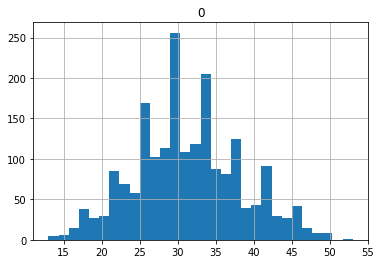

In [ ]:
label=pd.DataFrame(lab)
label
label.hist(bins=30);

Podemos ver que la distribución de los conteos de objetos tienen una similitud a una normal, a continuación vemos los parametros de esta

In [ ]:
label.describe()

,0
count,2000.000000
mean,31.157500
std,6.945417
min,13.000000
25%,26.000000
50%,31.000000
75%,36.000000
max,53.000000


La media y la mediana son cercanas por lo que se puede esperar que los datos se distribuyan de manera normal con media de 30 personas por imagen.

**Ver una imagen**

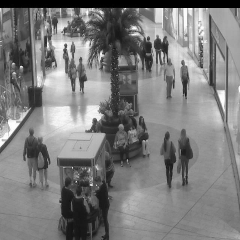

In [ ]:
img_gris = cv2.resize(img[1390], (240,240))
cv2_imshow(img_gris)

Realizamos una pequeña visualización del dataset

# Procesamiento de los datos

Se separa en validación y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, lab, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(1600, 240, 240)
(400, 240, 240)


Se aumenta una dimensión del objeto matricial

In [ ]:
train_X = x_train.reshape(-1, 240,240, 1)
test_X = x_test.reshape(-1, 240,240, 1)
train_X.shape, test_X.shape

((1600, 240, 240, 1), (400, 240, 240, 1))

Se normalizan los pixeles para poder mejorar el proceso de optimización

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Contrucción del modelo

# Protocolo experimental: Cuadro Latino


Aqui se proceden a realizar las diferentes arquitecturas expuestas en el documento entregable, para determiner cual es la mejor configuración de red

In [ ]:
# Build the keras model using the functional API.
# https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class

input_layer = tensorflow.keras.layers.Input(shape=(240, 240, 1))
conv_layer1 = tensorflow.keras.layers.Conv2D(filters=32,
                                             kernel_size=3,
                                             activation="relu")(input_layer)
max_pool1 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),
                                                 strides=3)(conv_layer1)
conv_layer2 = tensorflow.keras.layers.Conv2D(filters=16,
                                             kernel_size=3,
                                             activation="relu")(max_pool1)

max_pool11 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),
                                                 strides=3)(conv_layer2)
conv_layer22 = tensorflow.keras.layers.Conv2D(filters=8,
                                             kernel_size=3,
                                             activation="relu")(max_pool11)

flatten_layer  = tensorflow.keras.layers.Flatten()(conv_layer22)
dense_layer = tensorflow.keras.layers.Dense(8, activation="relu")(flatten_layer)
output_layer = tensorflow.keras.layers.Dense(8, activation="linear")(dense_layer)

model = tensorflow.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0     

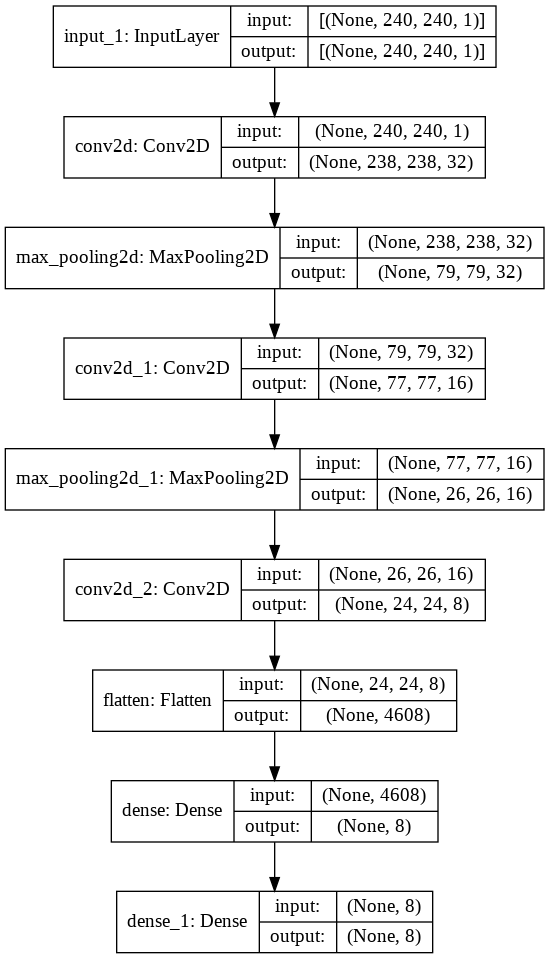

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Implementación del entrenamiento del AG

In [ ]:
import pygad.kerasga
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=5)

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)
    model.set_weights(weights=model_weights_matrix)
    predictions = model.predict(data_inputs)

    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    solution_fitness = 1.0 / abs_error

    print(solution_fitness, abs_error)
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
# Data inputs
data_inputs = x_train

# Data outputs
data_outputs = y_train

ga_instance = pygad.GA(num_generations=750, 
                       num_parents_mating=4, 
                       initial_population=keras_ga.population_weights,
                       fitness_func=fitness_func,
                       callback_generation=callback_generation,
                       crossover_type="single_point",
                       mutation_type="random",
                       parent_selection_type = "sss",
                       mutation_percent_genes=25)

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


In [ ]:
ga_instance.run()

0.03867009587698286 25.85977555321289
6.823848326322785e-06 146544.87500001
5.536098476119386e-06 180632.62500001
2.620511810523207e-05 38160.48437501
9.748977537897819e-06 102574.85937501
2.282982249009882e-05 43802.35546876
Generation = 1
2.282982249009882e-05 43802.35546876
Fitness    = 0.03867009587698286
0.0009703527158588243 1030.5531005959374
Generation = 2
0.0009703527158588243 1030.5531005959374
Fitness    = 0.03867009587698286
2.6511826552995706e-05 37719.01562501
Generation = 3
2.6511826552995706e-05 37719.01562501
Fitness    = 0.03867009587698286
2.2520620443088136e-05 44403.75000001
Generation = 4
2.2520620443088136e-05 44403.75000001
Fitness    = 0.03867009587698286


In [ ]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

In [ ]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)

In [ ]:
#### MAE con datos de entrenamiento
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predictions : \n", predictions)

mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(data_outputs, predictions).numpy()
print("Absolute Error : ", abs_error)

In [ ]:
#### MAE con datos de prueba
test_X = x_test.reshape(-1, 240,240, 1)
model.set_weights(best_solution_weights)
predictions = model.predict(test_X)
print("Predictions : \n", predictions)

mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(y_test, predictions).numpy()
print("Absolute Error : ", abs_error)